In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
df = pd.read_csv('./data/train.csv')

## EDA

In [3]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df.shape

(7613, 5)

In [5]:
df.keyword.value_counts()

fatalities               45
armageddon               42
deluge                   42
damage                   41
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [6]:
df.location.value_counts()

USA                           104
New York                       71
United States                  50
London                         45
Canada                         29
                             ... 
Dallas, TX                      1
Nairobi, Kenya                  1
Black Canyon New River, AZ      1
Westerland                      1
Valle Del Sol                   1
Name: location, Length: 3341, dtype: int64

Text(0.5, 0, 'Length of tweet')

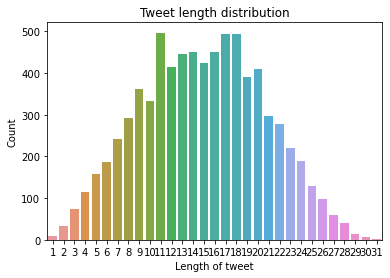

In [7]:
plot = df.text.str.split().apply(len).value_counts().sort_index()
sns.barplot(plot.index, plot.values)
plt.title('Tweet length distribution')
plt.ylabel('Count')
plt.xlabel('Length of tweet')

In [8]:
df.keyword = df.keyword.fillna('')
df.location = df.location.fillna('')

In [9]:
# train test split
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, stratify=df.target)

In [10]:
train.shape

(5709, 5)

In [11]:
test.shape

(1904, 5)

## Bag-of-Words

In [12]:
vectorizer = CountVectorizer()
vectorizer = vectorizer.fit(
    pd.concat([df.text, df.keyword, df.location]))

In [13]:
import scipy

In [14]:
feature_keyword = vectorizer.transform(train.keyword)
feature_location = vectorizer.transform(train.location)
feature_text = vectorizer.transform(train.text)
feature = scipy.sparse.hstack([feature_keyword, feature_location, feature_text])
feature.shape

(5709, 70467)

In [15]:
feature_keyword_test = vectorizer.transform(test.keyword)
feature_location_test = vectorizer.transform(test.location)
feature_text_test = vectorizer.transform(test.text)
feature_test = scipy.sparse.hstack([feature_keyword_test, feature_location_test, feature_text_test])

In [16]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(feature, train.target)

LogisticRegression()

In [17]:
lr.score(feature_test, test.target)

0.7888655462184874

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
score = []
for i in range(50, 200+50, 50):
    print('Number of trees:', i)
    rf = RandomForestClassifier(n_estimators=i)
    rf.fit(feature, train.target)
    score.append(rf.score(feature_test, test.target))

Number of trees: 50
Number of trees: 100
Number of trees: 150
Number of trees: 200


Text(0.5, 0, 'Number of trees')

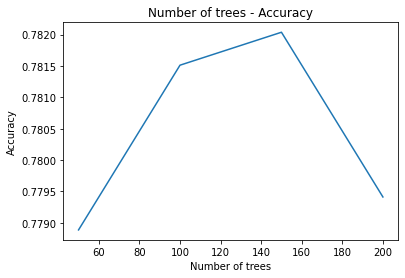

In [20]:
sns.lineplot(range(50, 200+50, 50), score)
plt.title('Number of trees - Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of trees')

## Word2Vec

In [21]:
from gensim.models import Word2Vec

In [22]:
model = Word2Vec(sentences=[i.lower().strip().split() for i in df.text], size=100, window=5, min_count=1, workers=4)

In [23]:
model.wv['our'].shape

(100,)

In [24]:
def text_to_vector(sent):
    if not sent:
        return np.zeros((100,))
    sent_vec = []
    for w in sent.split():
        try:
            sent_vec.append(model.wv[w])
        except:
            sent_vec.append(np.zeros((100,)))
    return np.mean(np.array(sent_vec), axis=0)

In [25]:
feature_keyword_train = [text_to_vector(i.strip()) for i in train.keyword]
feature_location_train = [text_to_vector(i.strip()) for i in train.location]
feature_text_train = [text_to_vector(i.strip()) for i in train.text]
feature_train = [np.concatenate(i) for i in zip(feature_keyword_train, feature_location_train, feature_text_train)]

In [26]:
feature_keyword_test = [text_to_vector(i.strip()) for i in test.keyword]
feature_location_test = [text_to_vector(i.strip()) for i in test.location]
feature_text_test = [text_to_vector(i.strip()) for i in test.text]
feature_test = [np.concatenate(i) for i in zip(feature_keyword_test, feature_location_test, feature_text_test)]

In [27]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(feature_train, train.target)

LogisticRegression()

In [28]:
lr.score(feature_test, test.target)

0.5714285714285714

In [29]:
from sklearn.ensemble import RandomForestClassifier
score = []
for i in range(50, 200+50, 50):
    print('Number of trees:', i)
    rf = RandomForestClassifier(n_estimators=i)
    rf.fit(feature_train, train.target)
    score.append(rf.score(feature_test, test.target))

Number of trees: 50
Number of trees: 100
Number of trees: 150
Number of trees: 200


Text(0.5, 0, 'Number of trees')

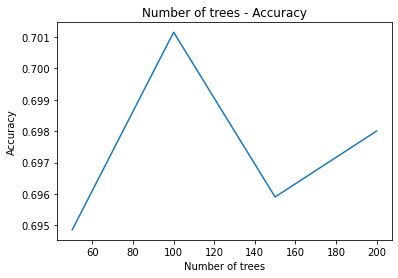

In [30]:
sns.lineplot(range(50, 200+50, 50), score)
plt.title('Number of trees - Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of trees')